In [13]:
import pandas as pd
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import os
filepath = os.getcwd()


In [10]:

def perform_elbow_analysis(file_path, max_clusters=10, sep=';'):
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)

    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))

    ts_data = to_time_series_dataset(list(uniform_series))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    ts_scaled = scaler.fit_transform(ts_data)

    inertia = []
    for k in range(1, max_clusters + 1):
        model = TimeSeriesKMeans(n_clusters=k, metric="euclidean", verbose=False)
        model.fit(ts_scaled)
        inertia.append(model.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method for Determining Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()


def fit_model_and_visualize_clusters(file_path, n_clusters, sep=';'):
    # Load and preprocess data
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)

    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))

    ts_data = to_time_series_dataset(list(uniform_series))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    ts_scaled = scaler.fit_transform(ts_data)

    # Fit the model
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True)
    y_pred = model.fit_predict(ts_scaled)

    # Visualize clusters
    plt.figure(figsize=(12, 8))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)
        for xx in ts_scaled[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=0.2)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.title(f"Cluster {yi + 1}")
        plt.xlim([0, max_length])
    plt.tight_layout()
    plt.show()

    return model, scaler



def predict_cluster(consumption_file, model, scaler):
    # Reshape the timeseries_sample
    data = pd.read_csv(consumption_file, index_col=0, sep=';')
    data = data.sample(1)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)
    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))
    ts_data = to_time_series_dataset(list(uniform_series))
    ts_scaled = scaler.fit_transform(ts_data)
    cluster = model.predict(ts_scaled)
    return cluster

Elbow analysis for 1 year of consumption data


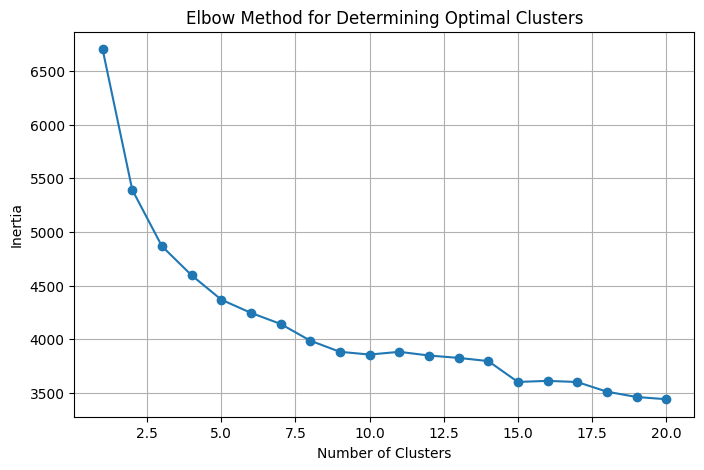

Elbow analysis for 3 years of consumption data


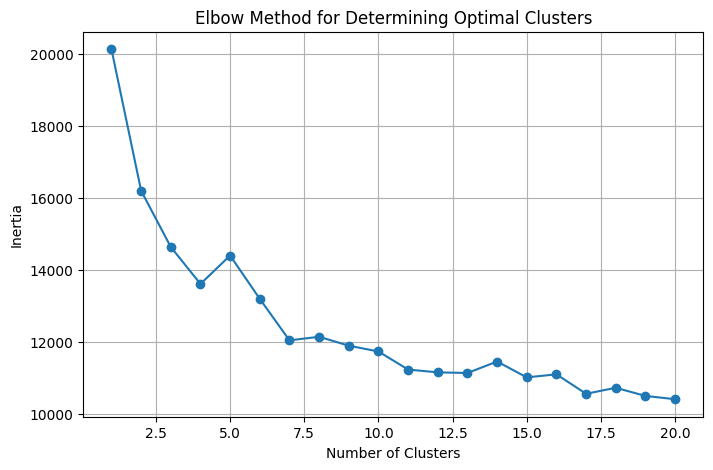

Elbow analysis for 1 year of production data


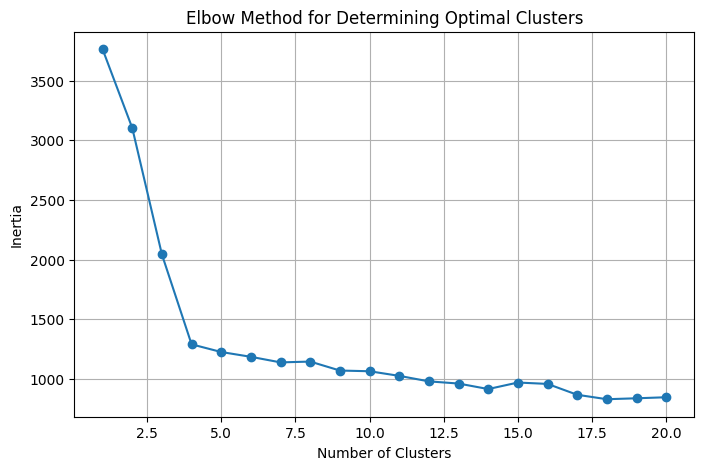

Elbow analysis for 3 years of production data


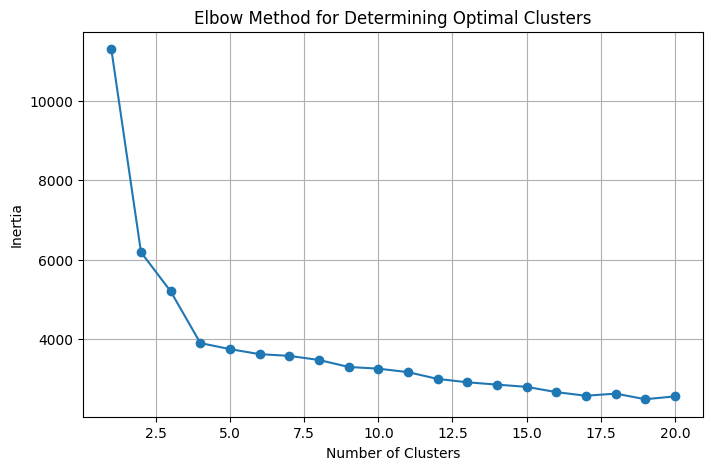

In [12]:
# Determine optimal clusters
consumption1y = filepath+"/dataset/consumption-1y-processed.csv"
print("Elbow analysis for 1 year of consumption data")
perform_elbow_analysis(consumption1y, max_clusters=20)

consumption3y = filepath+"/dataset/consumption-3y-processed.csv"
print("Elbow analysis for 3 years of consumption data")
perform_elbow_analysis(consumption3y, max_clusters=20)

production1y = filepath+"/dataset/production-1y-processed.csv"
print("Elbow analysis for 1 year of production data")
perform_elbow_analysis(production1y, max_clusters=20)

production3y = filepath+"/dataset/production-3y-processed.csv"
print("Elbow analysis for 3 years of production data")
perform_elbow_analysis(production3y, max_clusters=20)




4902.119 --> 3997.027 --> 3960.711 --> 3955.081 --> 3954.117 --> 3952.968 --> 3952.000 --> 3950.264 --> 3950.264 --> 


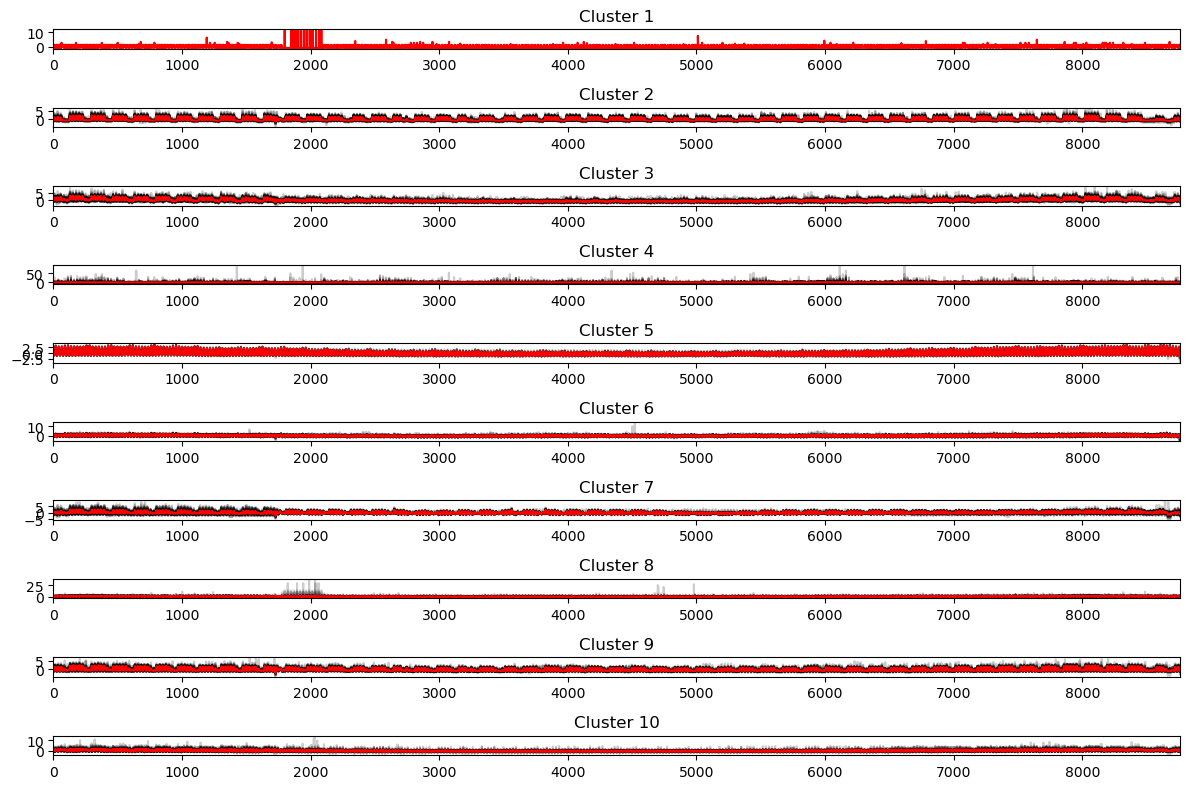

15710.272 --> 11984.901 --> 11652.973 --> 11563.207 --> 11527.364 --> 11518.908 --> 11518.908 --> 


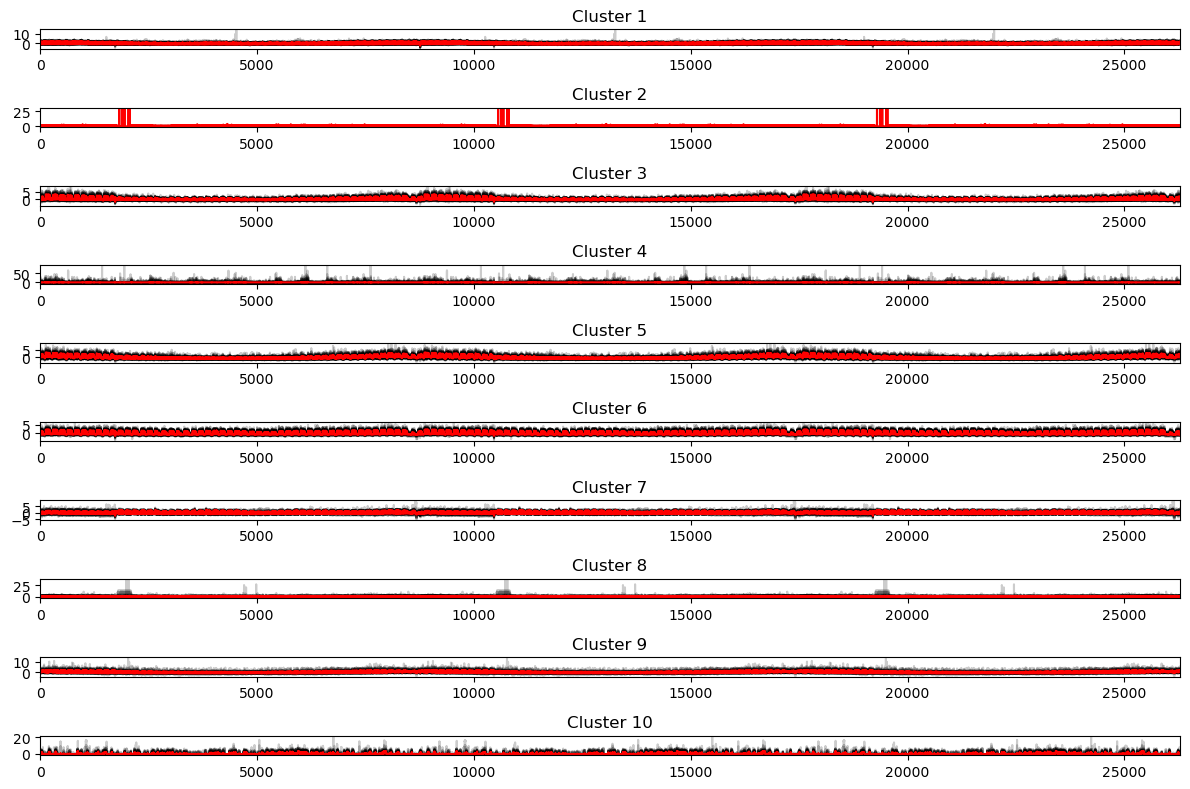

5145.877 --> 4040.851 --> 3992.926 --> 3972.339 --> 3959.922 --> 3949.987 --> 3942.837 --> 3937.279 --> 3934.486 --> 3933.309 --> 3933.007 --> 3933.007 --> 


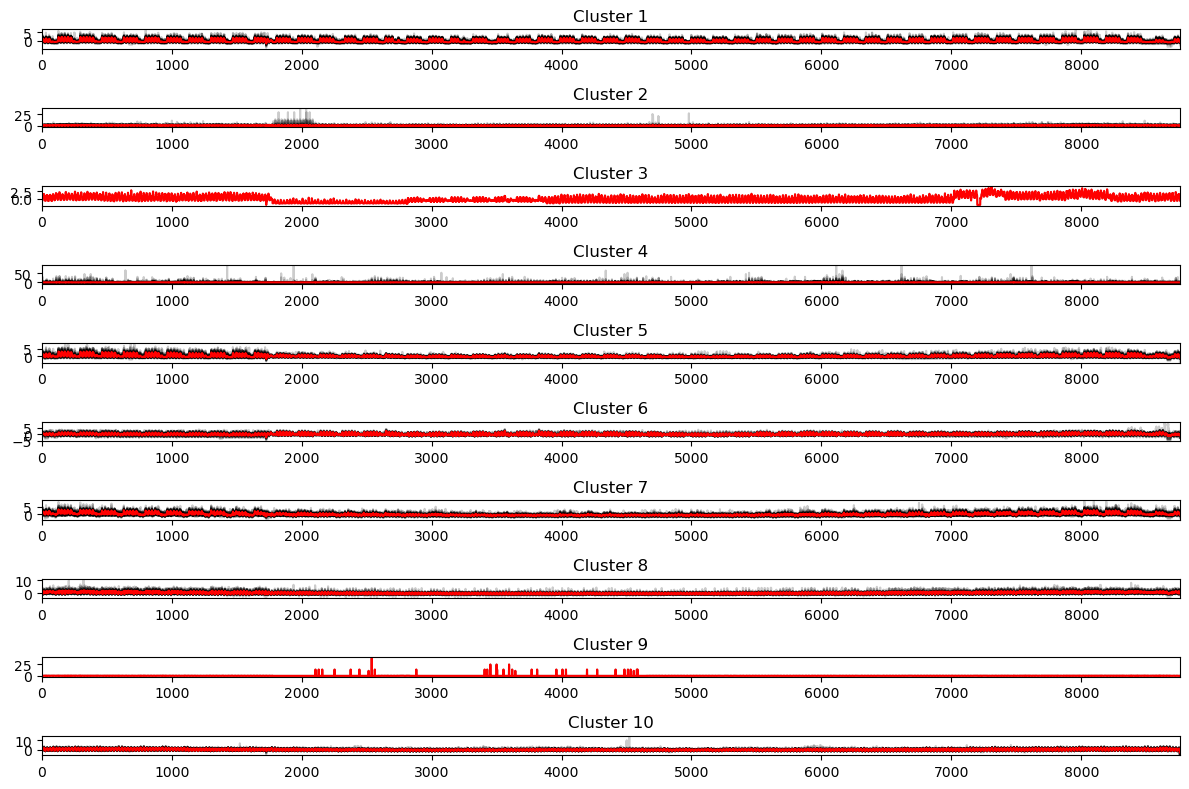

4124.831 --> 3268.340 --> 3227.797 --> 3201.728 --> 3191.659 --> 3188.752 --> 3186.332 --> 3182.275 --> 3164.629 --> 3148.379 --> 3143.824 --> 3140.953 --> 3139.813 --> 3139.636 --> 3138.995 --> 3138.995 --> 


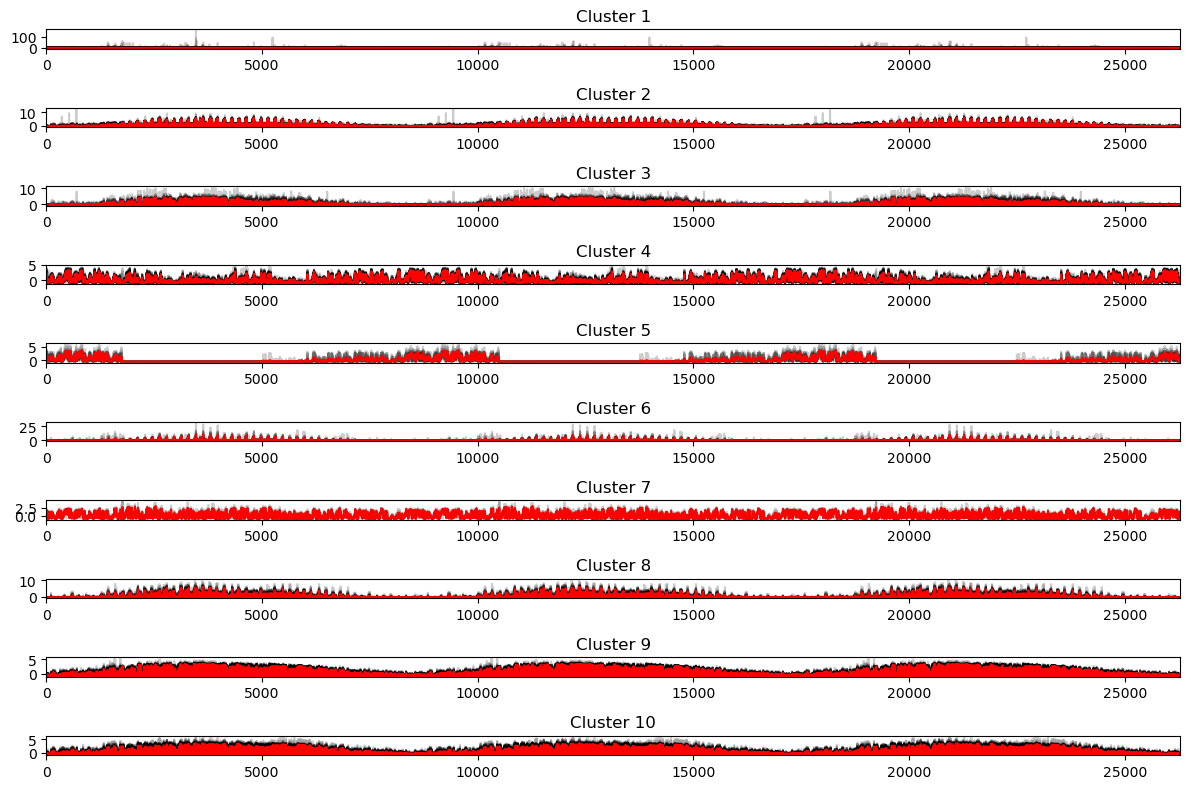

In [16]:
#Fit all the models using 10 clusters
model_consumption1y, scaler_consumption1y = fit_model_and_visualize_clusters(consumption1y, 10)
model_consumption3y, scaler_consumption3y = fit_model_and_visualize_clusters(consumption3y, 10)
model_production1y, scaler_production1y = fit_model_and_visualize_clusters(production1y, 10)
model_production3y, scaler_production3y = fit_model_and_visualize_clusters(production3y, 10)



In [1]:
# Calculate the silhouette score

